In [1]:
import os, math
from dataclasses import dataclass
import numpy as np
import pandas as pd
from numba import vectorize, float64, boolean, njit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import holoviews as hv
from IPython.display import Markdown
from holoviews.operation import decimate
import hvplot.pandas
#from holoviews.operation.datashader import datashade,rasterize, dynspread
#import dask.dataframe as dd

#import hvplot.dask

hv.extension('bokeh', logo = False)

In [2]:
# turn off numpy warning for overflow in np.exp()
np.seterr(over='ignore');

In [ ]:
shot_no = 0

### (Internal Tektronix format) .wfm parser

In [4]:
# wfm reader proof-of-concept
# https://www.tek.com/sample-license
# reads volts vs. time records (including fastframes) from little-endian version 3 WFM files

# See Also
# Performance Oscilloscope Reference Waveform File Format
# Tektronix part # 077-0220-10
# https://www.tek.com/oscilloscope/dpo7000-digital-phosphor-oscilloscope-manual-4

import struct
import time
import numpy as np # http://www.numpy.org/

class WfmReadError(Exception):
    """error for unexpected things"""
    pass

def read_wfm(target):
    """return sample data from target WFM file"""
    with open(target, 'rb') as f:
        hbytes = f.read(838)
        meta = decode_header(hbytes)
        # file signature checks
        if meta['byte_order'] != 0x0f0f:
            raise WfmReadError('big-endian not supported in this example')
        if meta['version'] != b':WFM#003':
            raise WfmReadError('only version 3 wfms supported in this example')
        if meta['imp_dim_count'] != 1:
            raise WfmReadError('imp dim count not 1')
        if meta['exp_dim_count'] != 1:
            raise WfmReadError('exp dim count not 1')
        if meta['record_type'] != 2:
            raise WfmReadError('not WFMDATA_VECTOR')
        if meta['exp_dim_1_type'] != 0:
            raise WfmReadError('not EXPLICIT_SAMPLE')
        if meta['time_base_1'] != 0:
            raise WfmReadError('not BASE_TIME')
        tfrac_array = np.zeros(meta['Frames'], dtype=np.double)
        tdatefrac_array = np.zeros(meta['Frames'], dtype=np.double)
        tdate_array = np.zeros(meta['Frames'], dtype=np.int32)
        tfrac_array[0] = meta['tfrac']
        tdatefrac_array[0] = meta['tdatefrac']
        tdate_array[0] = meta['tdate']
        # if fastframe, read fastframe table
        if meta['fastframe'] == 1:
            WUSp = np.fromfile(f, dtype='i4,f8,f8,i4', count=(meta['Frames'] - 1))
            # merge first frame trigger infos with frames > 1
            tfrac_array[1:] = WUSp['f1']
            tdatefrac_array[1:] = WUSp['f2']
            tdate_array[1:] = WUSp['f3']
        # read curve block
        bin_wave = np.memmap(filename = f,
                             dtype = meta['dformat'],
                             mode = 'r',
                             offset = meta['curve_offset'],
                             shape = (meta['avilable_values'], meta['Frames']),
                             order = 'F')
        # close file
    # slice out buffer values
    bin_wave = bin_wave[meta['pre_values']:meta['avilable_values'] - meta['post_values'],:]
    scaled_array = bin_wave * meta['vscale'] + meta['voffset']
    return scaled_array, meta['tstart'], meta['tscale'], tfrac_array, tdatefrac_array, tdate_array

def decode_header(header_bytes):
    """returns a dict of wfm metadata"""
    wfm_info = {}
    if len(header_bytes) != 838:
        raise WfmReadError('wfm header bytes not 838')
    wfm_info['byte_order'] = struct.unpack_from('H', header_bytes, offset=0)[0]
    wfm_info['version'] = struct.unpack_from('8s', header_bytes, offset=2)[0]
    wfm_info['imp_dim_count'] = struct.unpack_from('I', header_bytes, offset=114)[0]
    wfm_info['exp_dim_count'] = struct.unpack_from('I', header_bytes, offset=118)[0]
    wfm_info['record_type'] = struct.unpack_from('I', header_bytes, offset=122)[0]
    wfm_info['exp_dim_1_type'] = struct.unpack_from('I', header_bytes, offset=244)[0]
    wfm_info['time_base_1'] = struct.unpack_from('I', header_bytes, offset=768)[0]
    wfm_info['fastframe'] = struct.unpack_from('I', header_bytes, offset=78)[0]
    wfm_info['Frames'] = struct.unpack_from('I', header_bytes, offset=72)[0] + 1
    wfm_info['summary_frame'] = struct.unpack_from('h', header_bytes, offset=154)[0]
    wfm_info['curve_offset'] = struct.unpack_from('i', header_bytes, offset=16)[0] # 838 + ((frames - 1) * 54)
    # scaling factors
    wfm_info['vscale'] = struct.unpack_from('d', header_bytes, offset=168)[0]
    wfm_info['voffset'] = struct.unpack_from('d', header_bytes, offset=176)[0]
    wfm_info['tstart'] = struct.unpack_from('d', header_bytes, offset=496)[0]
    wfm_info['tscale'] = struct.unpack_from('d', header_bytes, offset=488)[0]
    # trigger detail
    wfm_info['tfrac'] = struct.unpack_from('d', header_bytes, offset=788)[0] # frame index 0
    wfm_info['tdatefrac'] = struct.unpack_from('d', header_bytes, offset=796)[0] # frame index 0
    wfm_info['tdate'] = struct.unpack_from('I', header_bytes, offset=804)[0] # frame index 0
    # data offsets
    # frames are same size, only first frame offsets are used
    dpre = struct.unpack_from('I', header_bytes, offset=822)[0]
    wfm_info['dpre'] = dpre
    dpost = struct.unpack_from('I', header_bytes, offset=826)[0]
    wfm_info['dpost'] = dpost
    readbytes = dpost - dpre
    wfm_info['readbytes'] = readbytes
    allbytes = struct.unpack_from('I', header_bytes, offset=830)[0]
    wfm_info['allbytes'] = allbytes
    # sample data type detection
    code = struct.unpack_from('i', header_bytes, offset=240)[0]
    wfm_info['code'] = code
    bps = struct.unpack_from('b', header_bytes, offset=15)[0]  # bytes-per-sample
    wfm_info['bps'] = bps
    if code == 7 and bps == 1:
        dformat = 'int8'
        samples = readbytes
    elif code == 0 and bps == 2:
        dformat = 'int16'
        samples = readbytes // 2
    elif code == 4 and bps == 4:
        dformat = 'single'
        samples = readbytes // 4
    else:
        raise WfmReadError('data type code or bytes-per-sample not understood')
    wfm_info['dformat'] = dformat
    wfm_info['samples'] = samples
    wfm_info['avilable_values'] = allbytes // bps
    wfm_info['pre_values'] = dpre // bps
    wfm_info['post_values'] = (allbytes - dpost) // bps
    return wfm_info

def readwfm(path):
    volts, tstart, tscale, tfrac, tdatefrac, tdate = read_wfm(path)
    toff = tfrac * tscale
    samples, frames = volts.shape
    tstop = samples * tscale + tstart
    volts = volts.reshape(len(volts))
    time = np.linspace(tstart+toff, tstop+toff, num=samples, endpoint=False)
    time = time.reshape(len(volts))
    
    return time,volts

### Get Hi-Res data from MSO58 oscilloscope

In [6]:
err = None
# load data locally
fnames = ['DAS_raw_data_dir/ch1.wfm',
          'DAS_raw_data_dir/ch2.wfm',
          'DAS_raw_data_dir/ch3.wfm',
          'DAS_raw_data_dir/ch4.wfm',
          'DAS_raw_data_dir/ch5.wfm',
          'DAS_raw_data_dir/ch6.wfm',
          'DAS_raw_data_dir/ch7.wfm']
ds = np.DataSource()
if not os.path.isfile('DAS_raw_data_dir/ch6.wfm'):
        # or download from web (slow)
        for i, ch_no in enumerate(range(1,8)):
            try:
                file = ds.open(f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Devices/Oscilloscopes/TektrMSO58-a/ch{ch_no}.wfm', mode = 'rb')
                fnames[i] = file.name
                file.close()
            except (ConnectionError, FileNotFoundError) as e:
                err = Markdown('### Can not download data')
if err is not None:
    t_vec, y_ch1 = readwfm(fnames[0])        
    _, y_ch2 = readwfm(fnames[1])
    _, y_ch3 = readwfm(fnames[2])
    _, y_ch4 = readwfm(fnames[3])
    _, y_ch5 = readwfm(fnames[4])
    _, y_ch6 = readwfm(fnames[5])
    _, y_ch7 = readwfm(fnames[6])
else:
    err

Check if data has sufficient sample rate

In [7]:
dt = t_vec[1]-t_vec[0]
MSamples =  1e-6/(dt) 

downsample = int(np.rint(float(1e-6) / dt))

if MSamples >= 120:
    out = Markdown(f'### Data with {MSamples:.1f}MS/s resolution') 
    low_res_data = False
else:
    out = Markdown('### Low resolution for peak recononstruction \n adjust oscilloscope settings')
    low_res_data = True
out

### Data with 250.0MS/s resolution

In [8]:
# class for storing channels and their parameters and results

@dataclass
class channel:
    name : str
    time : np.ndarray
    y :  np.ndarray
    noPlot : bool = False
    noFit : bool = False

    ## parameters for peak detection
    mean_noise_threshold_mult : float = 3.5
    peak_prominence_thr : float = 0.001

    # peak rise / fall time
    rise_time : float = None
    fall_time : float = None
    
    # calibration
    calibration : float = None  # keV/V
    
    # Flip waveform of PMTs but no SiPMs
    flip_waveform : bool = True
    
    ## parameters recieved from further analysis
    mean_channel_noise : float = 0
    
    # threshold
    threshold : float = 0
    
    # arrays for results
    simple_peak_loc : np.ndarray = None
    lonely_peak_loc : np.ndarray = None
    
    # for debug
    lonely_peak_mask : np.ndarray = None
    
    no_corr_peak_height : np.ndarray = None
    lonely_peak_height : np.ndarray = None
    simple_corr_peak_height : np.ndarray = None
    simple_corr_peak_err : np.ndarray = None

    simple_corr_peak_filtered_loc : np.ndarray = None
    simple_corr_peak_filtered_height : np.ndarray = None
    

In [9]:
# set channel and their parameters
ch1 = channel('LYSO 6', t_vec, y_ch2, rise_time=6.180e-09, fall_time=5.215e-08, calibration=3644., flip_waveform=False)  # @ C:300mV
ch2 = channel('LYSO 7', t_vec, y_ch2, rise_time=6.106e-09, fall_time=5.382e-08, calibration=3711., flip_waveform=False)  # @ @ C:300mV
ch3 = channel('CeBr-a', t_vec, y_ch3, rise_time=1.457e-09, fall_time=2.754e-08, calibration=12578.)  # @ HV:600 V
ch4 = channel('CeBr-b', t_vec, y_ch4, rise_time=3.410e-09, fall_time=2.786e-08, calibration=6714.)   # @ HV:600 V
ch5 = channel('LYSO 3', t_vec, y_ch5, rise_time=6.124e-09, fall_time=5.355e-08, calibration=4884.5, flip_waveform=False)  # @ @ C:300mV
ch6 = channel('LYSO 1', t_vec, y_ch6, rise_time=6.004e-09, fall_time=5.149e-08, calibration=4959.8, flip_waveform=False) # @ @ C:300mV
ch7 = channel('LYSO 5', t_vec, y_ch7, rise_time=6.194e-09, fall_time=5.381e-08, calibration=3564., flip_waveform=False, ) # @ C:300mV mod


channels = [ch3,ch4,ch6,ch5,ch7,ch1,ch2]

### Show raw data

Note: [SiPM](https://www.ketek.net/wp-content/uploads/KETEK-SiPM-Module-PE33xx-WB-TIA-xP.pdf) has range from 0V to +1V  
anything above is clipped

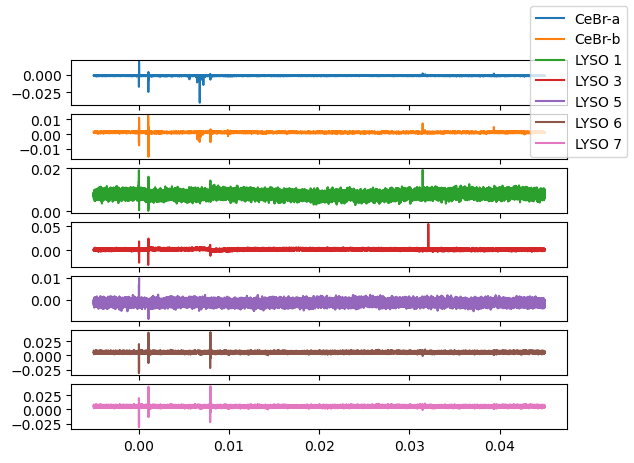

In [10]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(len(channels), sharex  =True)
[ax.plot(ch.time[::downsample],ch.y[::downsample], 
         label = ch.name, color = c) for ax, ch, c in zip(axes, channels, color_cycle)]
[ax.axhline(1., color = 'red', ls = '--') 
    for ax, ch in zip(axes, channels) if not ch.flip_waveform and np.any(ch.y > 1.)]

fig.legend()

is_clipping = [np.any(ch.y > 1.) for ch in channels if not ch.flip_waveform]
if np.any(is_clipping):
    warning = Markdown("""### SiPM's TIA amplifier saturated""")
    display(warning)

### Remove offset from OSC waveforms and flip

In [11]:
def get_noise_level(t,y_vals,noise_time):
    y_noise = y_vals[t < noise_time]
    y_noise = np.nan_to_num(y_noise, posinf = 0, neginf = 0)

    mean_y = np.mean(y_noise)
    
    # mean noise amplitude
    abs_noise = np.abs(y_noise - mean_y)**2
    mean_noise_ampl = np.sqrt(np.mean(abs_noise))

    return mean_y, mean_noise_ampl

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'save') / w


for ch in channels:
    noise, ch.mean_channel_noise = get_noise_level(ch.time, ch.y, 0.000)
    ch.y = ch.y - noise
    ch.threshold = ch.mean_channel_noise*ch.mean_noise_threshold_mult
    
    if ch.flip_waveform:
        ch.y *=-1
    
    ## smooth-out noise
    ch.y = moving_average(ch.y, 5)

### Plot OSC waveforms and peak thresholds

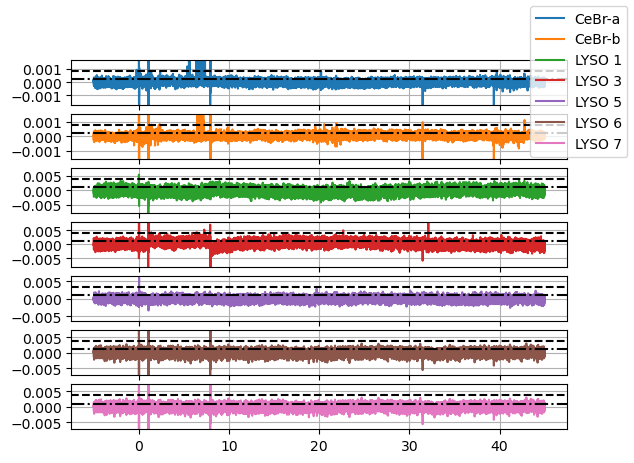

In [12]:
#%matplotlib widget
fig, axes = plt.subplots(len(channels), sharex  =True)
for ax,ch,color in zip(axes,channels, color_cycle):
    ax.plot(ch.time[::downsample]*1e3, ch.y[::downsample], label = ch.name, color=color)
    ax.axhline(ch.mean_channel_noise,ls= '-.', c = 'k')
    ax.axhline(ch.threshold,ls= '--', c = 'k')
    ax.set_ylim(-2*ch.threshold, 2*ch.threshold)
    ax.grid()

fig.legend();

### Find peaks

In [13]:
max_HXR_energy = 10.

for ch in channels:
    peaks_loc, _ = find_peaks(ch.y, height=ch.threshold, prominence = ch.mean_channel_noise*2)
    ch.simple_peak_loc = peaks_loc
    ch.no_corr_peak_height = ch.y[peaks_loc]
    
    if ch.calibration is not None and not ch.noPlot and not ch.noFit:
        if ch.name == 'NaITl':
            continue
        max_HXR_energy = np.max((max_HXR_energy, ch.no_corr_peak_height.max()*ch.calibration))

### Define useful functions

In [14]:
def get_index(oneDArray, val):
    diff = np.abs(oneDArray - val)
    return np.argmin(diff)

def exp_decay(t,height,decay_time):
    return height * np.exp(-t/decay_time)

@njit
def is_lonely_peak(time, HXR_y, peaks, peak_no , fall_time, mean_noise_level):
    peak_fall_time =  fall_time * np.log(HXR_y[peaks[peak_no]]/mean_noise_level)
    
    # by defintion first peak is lonely
    if peak_no == 0:
        return True
    
    if peak_no != 0:
        t_before = time[peaks[peak_no]] - peak_fall_time
        t_peak_before = time[peaks[peak_no-1]]
        if  t_before < t_peak_before:
            return False

    if peak_no <= peaks.size-2:
        t_after  = time[peaks[peak_no]] + peak_fall_time
        t_peak_after = time[peaks[peak_no+1]]
        if t_peak_after < t_after:
            return False
    return True

def identify_lonely_peaks(time,HXR_y, peaks, channel_props):
    def is_lonely_peak_reduced(n):
        return is_lonely_peak(time,
                              HXR_y,
                              peaks, 
                              n, 
                              channel_props.fall_time, 
                              channel_props.mean_channel_noise)
    
    lonely_peaks_idx = [is_lonely_peak_reduced(n) for n in  range(peaks.size)]
    lonely_peaks_idx = np.array(lonely_peaks_idx, np.bool_)
    return lonely_peaks_idx

def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def estimate_baseline(time, HXR_y, current_peak_idx,peak_loc_arr, channel_props):
    fall_time = channel_props.fall_time
    
    # if current peak is lonely, no need to find previous
    if is_lonely_peak(time, HXR_y, peak_loc_arr, current_peak_idx, fall_time,channel_props.mean_channel_noise):
        return 0
    
    prev_peak_index = peak_loc_arr[current_peak_idx-1]

    prev_peak_time = time[prev_peak_index]
    curr_peak_time = time[peak_loc_arr[current_peak_idx]]
    
    prev_peak_height = HXR_y[prev_peak_index]
    baseline_estimate = exp_decay(curr_peak_time-prev_peak_time,prev_peak_height,fall_time)

    return baseline_estimate

def simple_peak_correction(time, data_y,peak_loc_array, channel_props):
    
    corrected_peak_heights = np.zeros_like(peak_loc_array, float)
        
    
    for n, peak in enumerate(peak_loc_array):
        # find prev peak and use decay time to calculate baseline for current peak
        peak_height = data_y[peak]
        
        baseline = estimate_baseline(time, data_y, n,peak_loc_array,channel_props)
        # hotfix
        #if baseline < 0 or baseline > 1:
        #    baseline= 0
        
        corrected_peak_heights[n] = peak_height - baseline
   
    
    
    return corrected_peak_heights

In [15]:
for ch in channels:
    if ch.noFit or ch.rise_time is None or ch.rise_time is None:
        continue
    
    ch.simple_corr_peak_height  =  simple_peak_correction(ch.time, ch.y,ch.simple_peak_loc, ch)
    
    ch.lonely_peak_mask = identify_lonely_peaks(ch.time, ch.y,
                                                ch.simple_peak_loc,
                                                ch)
    
    ch.lonely_peak_loc = ch.simple_peak_loc[ch.lonely_peak_mask].copy()
    ch.lonely_peak_height = ch.no_corr_peak_height[ch.lonely_peak_mask].copy()



In [16]:
plots = list()
for ch in channels:
    if ch.noFit or ch.rise_time is None or ch.rise_time is None or ch.noPlot:
        continue

    
    waveform = decimate(hv.Curve((ch.time*1e3, ch.y), 't','U_%s' % ch.name, label = ch.name))
    peaks_pl = hv.ErrorBars((ch.time[ch.simple_peak_loc]*1e3,ch.y[ch.simple_peak_loc],ch.simple_corr_peak_height,0),
                            vdims=['U_%s' % ch.name, 'yerrneg', 'yerrpos'],label = 'peaks').opts(upper_head=None, lower_head=None)
    
    plot = waveform * peaks_pl
    plot.opts(width=950, height = 200).relabel(ch.name)
    plots.append(plot)

hv.Layout(plots).cols(1)

ModuleNotFoundError: No module named 'jupyter_bokeh'

:Layout
   .DynamicMap.I   :DynamicMap   []
   .DynamicMap.II  :DynamicMap   []
   .DynamicMap.III :DynamicMap   []
   .DynamicMap.IV  :DynamicMap   []
   .DynamicMap.V   :DynamicMap   []
   .DynamicMap.VI  :DynamicMap   []
   .DynamicMap.VII :DynamicMap   []

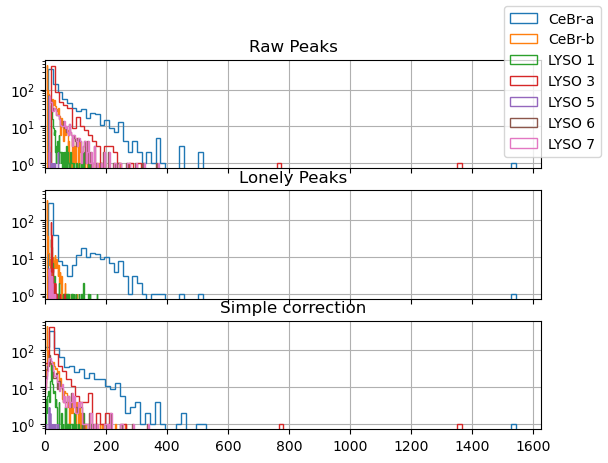

In [17]:
fig, axes = plt.subplots(3, sharex = True, sharey=True)
(ax,ax2,ax3) = axes
for ch, color in zip(channels, color_cycle):
    ax.hist(ch.no_corr_peak_height*ch.calibration, bins = 100, label = '%s' % ch.name, histtype = 'step', color = color)
    if ch.noFit or ch.rise_time is None or ch.fall_time is None:
        continue
    ax2.hist(ch.simple_corr_peak_height[ch.lonely_peak_mask]*ch.calibration, bins = 100, histtype = 'step', color = color)
    ax3.hist(ch.simple_corr_peak_height*ch.calibration, bins = 100, histtype = 'step', color = color)

ax.set_title('Raw Peaks')
ax2.set_title('Lonely Peaks')    
ax3.set_title('Simple correction')    

[a.grid() for a in axes];
[a.semilogy() for a in axes];
ax.set_xlim(0)

fig.legend();


In [18]:
ip_url = f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/BasicDiagnostics/Results/Ip.csv'
ip = ds.open(ip_url)
ip = np.loadtxt(ip,delimiter=',')

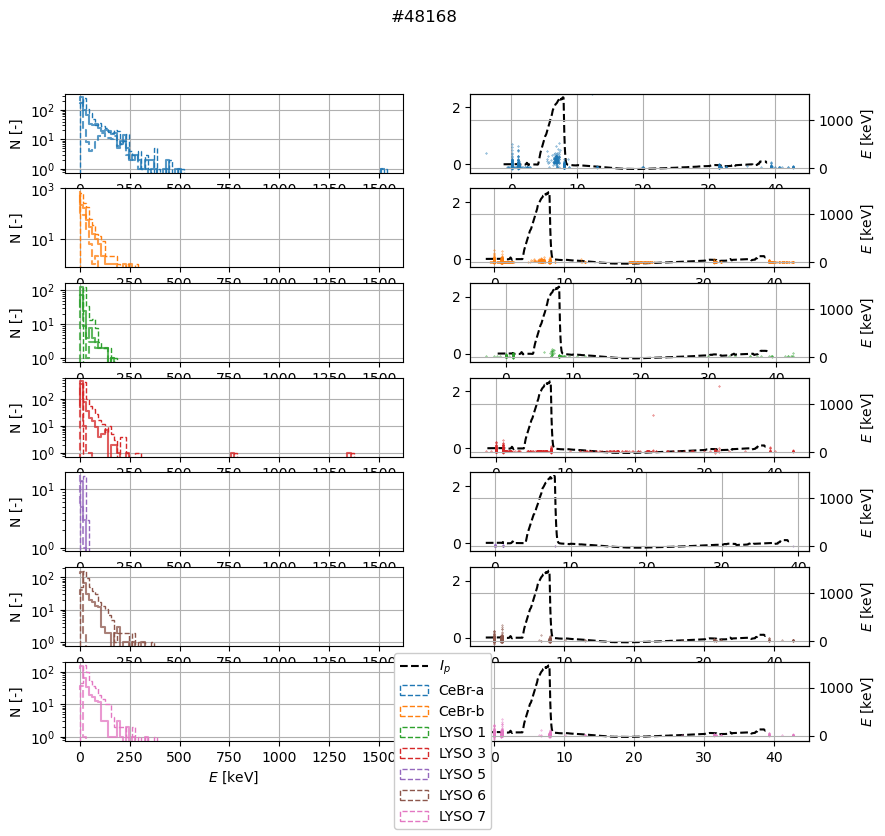

In [19]:
plot_channels = []

for ch,color in zip(channels,color_cycle):
    if ch.noPlot or ch.calibration is None or ch.noFit:
        continue
    plot_channels.append(ch)

fig, axes = plt.subplots(nrows = len(plot_channels), ncols =2, figsize =  [1.5*6.4, 1.75*4.8])

prevAx = None
prevrAx = None
for ch,color,ax, rax in zip(plot_channels,color_cycle,axes[:,0],axes[:,1]):
    if ch.noPlot or ch.calibration is None:
        continue

    _, bins, _ = ax.hist(ch.no_corr_peak_height*ch.calibration, bins = 100, label = ch.name,
                         range = (0,max_HXR_energy), histtype = 'step', ls = '--', color = color)
    
    if ch.noFit or ch.rise_time is None or ch.rise_time is None:
        continue
    
    h1, b1 = np.histogram(ch.simple_corr_peak_height*ch.calibration, 
                          bins = len(bins)-1, range = (bins[0], bins[-1]))
  
    ax.step(bins[:-1], h1, color = color, alpha = .75)
    
    h3, b3 = np.histogram(ch.simple_corr_peak_height[ch.lonely_peak_mask]*ch.calibration, 
                          bins = len(bins)-1, range = (bins[0], bins[-1]))
    
    ax.step(bins[:-1], h3, color = color, ls = '--', alpha = .75)

    ip_l = rax.plot(ip[:,0],ip[:,1],'k--', label = '$I_p$')
    
    rax.grid(True,axis='x')
    rax = rax.twinx()
    
    peak_time = ch.time[ch.simple_peak_loc] * 1e3
    peak_height = ch.simple_corr_peak_height*ch.calibration
    rax.scatter(peak_time,peak_height, color = color,s = .1 )

    rax.grid(True)
    #rax.yaxis.tick_right()
    
    if not ch.flip_waveform:
        max_reliableE = ch.calibration * .9
        if np.any(ch.y[ch.simple_peak_loc]>max_reliableE):
            rax.axhline(max_reliableE/2,color = 'r',ls = '-')
    

    ax.semilogy()
    ax.grid()
    ax.set_ylabel('N [-]')    
    
    if prevAx is not None:
        ax.sharex(prevAx)

    prevAx = ax
    
    rax.yaxis.set_label_position("right")
    rax.set_ylabel('$E$ [keV]')
    
    if prevrAx is not None:
        #rax.sharex(prevrAx)
        rax.sharey(prevrAx)

    prevrAx = rax


newHandles = [ip_l[0]]
for ax in axes[:,0]:
    handles, labels = ax.get_legend_handles_labels()
    newHandles += handles

fig.legend(handles= newHandles,frameon =True, fancybox=True,framealpha=1.,loc = 'lower center')

ax.set_xlabel('$E$ [keV]')
rax.set_xlabel('t [ms]');
rax.set_ylim(-100,max_HXR_energy)

fig.suptitle(f"#{shot_no}");
plt.savefig('icon-fig.png')